In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import warnings
import gc
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

In [ ]:

df  = pd.read_csv('/content/drive/MyDrive/DataSet2020/2021_Competition_Training.csv' ,low_memory=False)
df.head()

,Unnamed: 0,ID,auth_3mth_post_acute_dia,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,bh_ncal_pmpm_ct,src_div_id,total_bh_copay_pmpm_cost_t_9-6-3m_b4,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,cons_chmi,mcc_ano_pmpm_ct_t_9-6-3m_b4,auth_3mth_post_acute_trm,rx_maint_pmpm_cost_t_12-9-6m_b4,auth_3mth_post_acute_rsk,cons_ltmedicr,rx_gpi4_6110_pmpm_ct,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,rx_nonbh_pmpm_cost_t_9-6-3m_b4,atlas_pct_laccess_nhna15,auth_3mth_acute_vco,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,auth_3mth_dc_ltac,cons_lwcm10,auth_3mth_post_acute_inj,atlas_fsrpth14,auth_3mth_dc_home,atlas_wicspth12,rx_gpi2_17_pmpm_cost_t_12-9-6m_b4,cons_hxmioc,rx_generic_pmpm_cost_t_6-3-0m_b4,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,...,bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4,zip_cd,auth_3mth_post_acute_ckd,atlas_pct_laccess_nhpi15,auth_3mth_post_acute_ner,auth_3mth_post_er,credit_num_consumerfinance_new,rx_gpi2_49_pmpm_cost_0to3m_b4,cons_chva,atlas_avghhsize,rx_overall_net_paid_pmpm_cost_6to9m_b4,atlas_ownhomepct,atlas_orchard_farms12,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,atlas_pct_fmrkt_wic16,rx_gpi2_33_pmpm_ct_0to3m_b4,auth_3mth_post_acute_chf,rwjf_social_associate_rate,atlas_freshveg_farms12,auth_3mth_acute_ccs_042,auth_3mth_post_acute_inf,auth_3mth_acute_sns,days_since_last_clm_0to3m_b4,auth_3mth_dc_other,auth_3mth_bh_acute_mean_los,mcc_end_pct,auth_3mth_post_acute_gus,cons_lwcm07,atlas_pct_fmrkt_otherfood16,auth_3mth_post_acute_end,auth_3mth_acute_mus,atlas_perpov_1980_0711,atlas_pct_laccess_white15,auth_3mth_post_acute_mean_los,rx_gpi2_66_pmpm_ct,auth_3mth_acute_gus,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd
0,0,1MObcfaSTac85Lca0Y8bbA6I,0,0.000000,7.910346,0.049413,0.000000,46.839102,0.0,0,0.0,000,No Activity,0.0,67.0,No Activity,0,Inc_1x-2x,0,4.0,0.0,8.068443,2366.225593,0.00,Dec_1x-2x,0.036550,0,22.614359,0.0,0,0.26716,0,0.904069,0,0.248279,No Activity,9.0,Dec_1x-2x,0.0,5.0,...,No Activity,No Activity,52161,0,0.000000,0,0,0.073287,3.956667,158.0,2.12,38.320000,73.922397,0.0,No Activity,0.0,0.33333334,0,23.839718,5.0,0,0,0,120,0,0.0,0.0,0,0.23359,0.00,0,0,0.0,26.842903,0.0,0.000000,0,Inc_1x-2x,0.0,1.0
1,1,5M89OSTL580dYeA849d3480I,0,0.000000,1.730272,0.095624,60.000000,36.721923,NaN,0,0.0,000,No Activity,0.0,69.0,No Activity,0,No Activity,0,3.0,0.0,12.354272,2926.079093,0.00,New,0.028851,0,19.627044,0.0,0,0.14265,0,0.721653,0,0.087810,No Activity,9.0,Inc_over_8x,0.0,6.0,...,No Activity,No Activity,55415,0,0.002699,0,0,0.228002,7.793334,254.0,2.58,0.000000,68.704457,21.0,No Activity,0.0,0.33333334,0,12.576445,69.0,0,0,0,120,0,0.0,0.0,0,0.19198,50.00,0,0,0.0,11.405128,0.0,0.000000,0,New,0.0,1.0
2,2,MdOS23TLe18Y60043Acfa2I9,0,0.000000,5.015501,0.022398,30.000000,39.605015,0.0,0,0.0,000,No Activity,0.0,76.0,No Activity,0,Dec_2x-4x,0,NaN,0.0,14.184090,4522.696898,0.17,New,0.086740,0,36.273675,0.0,0,0.25904,0,0.444301,0,0.103268,No Activity,3.0,Inc_1x-2x,0.0,1.0,...,No Activity,No Activity,29450,0,0.000000,0,0,0.502758,0.000000,118.0,2.57,1.186667,68.700726,10.0,Inc_1x-2x,0.0,0.0,0,9.649039,14.0,0,0,0,36,0,0.0,0.0,0,0.44111,0.00,0,0,0.0,1.713138,0.0,0.083333,0,Inc_1x-2x,0.0,1.0
3,3,2ccMO510abSaT79cLfaYAIe4,0,2.266667,4.049586,0.070407,50.000000,93.694818,0.0,0,0.0,000,No Activity,0.0,46.0,No Activity,0,Inc_1x-2x,0,8.0,0.0,25.220000,3993.478363,0.00,Dec_1x-2x,0.167049,0,34.035432,0.0,0,0.27952,0,0.696737,0,0.087032,No Activity,6.0,New,0.0,0.0,...,No Activity,No Activity,30108,0,0.023008,0,0,0.330044,0.000000,185.0,2.82,2.926667,53.014194,20.0,No Activity,0.0,0.0,0,11.351209,10.0,0,0,0,120,0,0.0,0.0,0,0.15418,0.00,0,0,0.0,11.853595,0.0,0.000000,0,Dec_1x-2x,0.0,1.0
4,4,0M9811Ocb1ST94LY3f5A9I00,0,0.000000,0.618606,0.074862,88.272489,36.298252,0.0,0,0.0,000,No Activity,0

In [ ]:
tdf = pd.read_csv('/content/drive/MyDrive/DataSet2020/2021_Competition_Holdout.csv',low_memory=False )
tdf.head()

,Unnamed: 0,ID,auth_3mth_post_acute_dia,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,bh_ncal_pmpm_ct,src_div_id,total_bh_copay_pmpm_cost_t_9-6-3m_b4,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,cons_chmi,mcc_ano_pmpm_ct_t_9-6-3m_b4,auth_3mth_post_acute_trm,rx_maint_pmpm_cost_t_12-9-6m_b4,auth_3mth_post_acute_rsk,cons_ltmedicr,rx_gpi4_6110_pmpm_ct,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,rx_nonbh_pmpm_cost_t_9-6-3m_b4,atlas_pct_laccess_nhna15,auth_3mth_acute_vco,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,auth_3mth_dc_ltac,cons_lwcm10,auth_3mth_post_acute_inj,atlas_fsrpth14,auth_3mth_dc_home,atlas_wicspth12,rx_gpi2_17_pmpm_cost_t_12-9-6m_b4,cons_hxmioc,rx_generic_pmpm_cost_t_6-3-0m_b4,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,...,bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4,zip_cd,auth_3mth_post_acute_ckd,atlas_pct_laccess_nhpi15,auth_3mth_post_acute_ner,auth_3mth_post_er,credit_num_consumerfinance_new,rx_gpi2_49_pmpm_cost_0to3m_b4,cons_chva,atlas_avghhsize,rx_overall_net_paid_pmpm_cost_6to9m_b4,atlas_ownhomepct,atlas_orchard_farms12,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,atlas_pct_fmrkt_wic16,rx_gpi2_33_pmpm_ct_0to3m_b4,auth_3mth_post_acute_chf,rwjf_social_associate_rate,atlas_freshveg_farms12,auth_3mth_acute_ccs_042,auth_3mth_post_acute_inf,auth_3mth_acute_sns,days_since_last_clm_0to3m_b4,auth_3mth_dc_other,auth_3mth_bh_acute_mean_los,mcc_end_pct,auth_3mth_post_acute_gus,cons_lwcm07,atlas_pct_fmrkt_otherfood16,auth_3mth_post_acute_end,auth_3mth_acute_mus,atlas_perpov_1980_0711,atlas_pct_laccess_white15,auth_3mth_post_acute_mean_los,rx_gpi2_66_pmpm_ct,auth_3mth_acute_gus,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd
0,0,5M9OS1T3dLc09Ybc7013AI9f,0,0.0,9.735346,0.131562,100.0,NaN,0.0,0,0.0,000,No Activity,0.0,NaN,No Activity,0,Dec_2x-4x,0,NaN,0.0,19.176009,1572.427508,0.0,Inc_1x-2x,0.462727,0,23.902786,1.0,0,NaN,0,0.768907,0,0.229941,Resolved,NaN,Inc_1x-2x,0.0,6.0,...,No Activity,No_Change,37301,0,0.007196,0,0,0.343095,2.383333,NaN,2.43,1907.250000,68.314377,15.0,Inc_1x-2x,0.0,1.0,0,12.163237,7.0,0,0,0,11,0,0.0,0.0,0,NaN,100.0,0,0,0.0,12.404716,0.0,0.333333,0,Dec_1x-2x,0.0,1.0
1,1,0M8f45b4a4Of6aS3TL6Ya9AI,0,0.0,6.264524,0.075427,75.0,23.833889,0.0,0,0.0,000,No Activity,0.0,NaN,No Activity,0,No Activity,0,NaN,0.0,17.286603,2130.109835,0.0,No Activity,0.158575,0,26.833861,0.0,0,NaN,0,0.671256,0,0.082403,No Activity,NaN,New,0.0,15.0,...,No Activity,No Activity,97023,0,0.033085,0,0,0.112537,0.000000,NaN,2.58,0.000000,54.660192,22.0,No Activity,75.0,0.0,0,13.250028,12.0,0,0,0,120,0,0.0,0.0,0,NaN,25.0,0,0,0.0,35.363608,0.0,0.000000,0,No Activity,0.0,1.0
2,2,12MOS912Tb204LYacA2fIc22,0,0.0,6.136065,0.106704,85.0,26.085757,0.0,0,0.0,000,No Activity,0.0,49.0,No Activity,0,Inc_2x-4x,0,8.0,0.0,19.106041,1806.043293,0.0,Dec_2x-4x,0.056065,0,10.346433,0.0,0,0.20606,0,0.550016,0,0.150577,No Activity,9.0,Inc_1x-2x,0.0,3.0,...,No Activity,No Activity,43645,0,0.023967,0,0,0.154732,3.166667,130.0,2.38,46.926668,68.774570,10.0,Inc_1x-2x,0.0,0.33333334,0,13.486984,29.0,0,0,0,30,0,0.0,0.6,0,0.21852,60.0,0,0,0.0,37.241558,0.0,0.000000,0,No_Change,0.0,1.0
3,3,M6O69S24T36LYec4AI5d0b56,0,0.0,1.244630,0.000000,NaN,64.748171,0.0,0,0.0,000,No Activity,0.0,31.0,No Activity,0,Dec_2x-4x,0,8.0,0.0,18.397765,2245.687853,0.0,Dec_1x-2x,0.015978,0,15.664997,0.0,0,0.16953,0,0.913622,0,0.228276,No Activity,7.0,Dec_1x-2x,0.0,0.0,...,No Activity,No Activity,74316,0,0.003000,0,0,0.101670,0.000000,51.0,2.45,20.696667,78.339429,3.0,No Activity,NaN,0.33333334,0,12.066459,4.0,0,0,0,120,0,0.0,0.0,0,0.27983,NaN,0,0,0.0,3.726617,0.0,0.000000,0,Inc_1x-2x,0.0,1.0
4,4,45947aM37Oc8S3dTLYA00Ica,0,0.0,8.009543,0.061276,87.5,61.518384,0.0,0,0.0,000,No Activity,0.0,39.0,No Activity,0,Dec_1x-2x,0,5.0,0.0,22.055936,3283.196626,

In [ ]:
dtypes = {}
for i in df.columns:
    dtype = df[i].dtype
    if dtype not in dtypes: dtypes[dtype] = 0
    dtypes[dtype] += 1
dtypes

{dtype('int64'): 51, dtype('float64'): 202, dtype('O'): 115}

In [ ]:
target = "covid_vaccination"

reg_cols, cat_cols = [], []
id = "ID"

for i in df.columns:
	if i not in [id, target]:
		if df[i].nunique() > 100:
			reg_cols.append(i)
		else:
			cat_cols.append(i)

tdf['auth_3mth_post_acute_mean_los'] = np.int64(tdf['auth_3mth_post_acute_mean_los'])
reg_cols.append('auth_3mth_post_acute_mean_los')
cat_cols = list(set(cat_cols) - set(['auth_3mth_post_acute_mean_los']))
reg_cols = list(set(reg_cols) - set(['Unnamed: 0']))
print(df.shape)
print(df.columns)

(974842, 368)
Index(['Unnamed: 0', 'ID', 'auth_3mth_post_acute_dia',
       'rx_gpi2_72_pmpm_cost_6to9m_b4', 'atlas_pct_laccess_child15',
       'atlas_recfacpth14', 'atlas_pct_fmrkt_frveg16',
       'atlas_pct_free_lunch14', 'bh_ip_snf_net_paid_pmpm_cost_9to12m_b4',
       'auth_3mth_acute_ckd',
       ...
       'auth_3mth_post_acute_end', 'auth_3mth_acute_mus',
       'atlas_perpov_1980_0711', 'atlas_pct_laccess_white15',
       'auth_3mth_post_acute_mean_los', 'rx_gpi2_66_pmpm_ct',
       'auth_3mth_acute_gus', 'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4',
       'atlas_low_education_2015_update', 'race_cd'],
      dtype='object', length=368)


In [ ]:
dtypes = {}
isnull = set()
for i in cat_cols:
    dtype = df[i].dtype
    if dtype not in dtypes: dtypes[dtype] = 0
    dtypes[dtype] += 1
    if df[i].isnull().sum() > 0:
        isnull.add((i, dtype))
    if dtype == 'float64': print(i, df[i].nunique())
dtypes, isnull

In [ ]:
dtypes = {}
isnullt = set()
for i in cat_cols:
    dtype = tdf[i].dtype
    if dtype not in dtypes: dtypes[dtype] = 0
    dtypes[dtype] += 1
    if tdf[i].isnull().sum() > 0:
        isnullt.add((i, dtype))
    if dtype == 'float64': print(i, tdf[i].nunique())
dtypes, isnullt, isnullt - isnull

In [ ]:
dtypes = {}
isnull = set()
for i in reg_cols:
    dtype = df[i].dtype
    if dtype not in dtypes: dtypes[dtype] = 0
    dtypes[dtype] += 1
    if df[i].isnull().sum() > 0:
        isnull.add((i, dtype))
    if dtype == 'float64': print(i, df[i].nunique())
dtypes, isnull

In [ ]:
dtypes = {}
isnullt = set()
for i in reg_cols:
    dtype = tdf[i].dtype
    if dtype not in dtypes: dtypes[dtype] = 0
    dtypes[dtype] += 1
    if tdf[i].isnull().sum() > 0:
        isnullt.add((i, dtype))
    if dtype == 'float64': print(i, tdf[i].nunique())
dtypes, isnullt, isnullt - isnull

In [ ]:
for i in tqdm(cat_cols):
    dtype = df[i].dtype
    assert dtype == tdf[i].dtype or i in ['auth_3mth_acute_mus', 'auth_3mth_acute_sns', 'auth_3mth_acute_cir', 'auth_3mth_snf_direct', 'auth_3mth_acute_cer', 'auth_3mth_dc_custodial', 'auth_3mth_dc_left_ama', 'auth_3mth_transplant', 'auth_3mth_post_acute_men', 'auth_3mth_post_acute_sns', 'auth_3mth_acute_chf', 'auth_3mth_acute_skn', 'auth_3mth_acute_res', 'auth_3mth_post_acute_mus']
    ie = LabelEncoder()
    if i in ['auth_3mth_snf_direct', 'auth_3mth_post_acute_sns', 'auth_3mth_post_acute_mus', 'auth_3mth_post_acute_men']:
        df[i] = df[i].apply(lambda x: 0).astype('int64')
        df[i] = ie.fit_transform(df[i])
        tdf[i] = ie.transform(tdf[i])
    if i in ['auth_3mth_acute_mus', 'auth_3mth_dc_custodial', 'auth_3mth_dc_left_ama', 'auth_3mth_transplant', 'auth_3mth_acute_res', 'auth_3mth_acute_chf']:
        df[i] = df[i].apply(lambda x: 1 if x  == '1' else 0).astype('int64')
        df[i] = ie.fit_transform(df[i])
        tdf[i] = ie.transform(tdf[i])
    elif i in ['auth_3mth_acute_sns', 'auth_3mth_acute_cir', 'auth_3mth_acute_skn', 'auth_3mth_acute_cer']:
        tdf[i] = tdf[i].apply(lambda x: 1 if x  == '1' else 0).astype('int64')
        df[i] = ie.fit_transform(df[i])
        tdf[i] = ie.transform(tdf[i])
    elif dtype == 'float64':    
        df[i] = ie.fit_transform(df[i].fillna(0.))
        tdf[i] = ie.transform(tdf[i].fillna(0.))
    elif dtype == 'O':    
        df[i] = ie.fit_transform(df[i].fillna('nan'))
        tdf[i] = ie.transform(tdf[i].fillna('nan'))
    else:
        df[i] = ie.fit_transform(df[i])
        tdf[i] = ie.transform(tdf[i])

  0%|          | 0/191 [00:00<?, ?it/s]

In [ ]:
for i in tqdm(reg_cols):
    dtype = df[i].dtype
    assert dtype == tdf[i].dtype or i in ['auth_3mth_post_acute_mean_los']
    if i == 'auth_3mth_post_acute_mean_los':
        tdf[i] = np.float64(tdf[i])
    elif dtype == 'float64':    
        df[i] = df[i].fillna(0.)
        tdf[i] = tdf[i].fillna(0.)
    elif dtype == 'O':
        assert False
#         df[i] = ie.fit_transform(df[i].fillna('nan'))
#         tdf[i] = ie.transform(tdf[i].fillna('nan'))
    elif dtype == 'int64':
        pass
#         df[i] = ie.fit_transform(df[i])
#         tdf[i] = ie.transform(tdf[i])

  0%|          | 0/174 [00:00<?, ?it/s]

In [ ]:
target_map = {"no_vacc": 0, 'vacc': 1}
df[target] = df[target].apply(lambda x: target_map[x]).astype(np.int64)
# shd not be any null value
sum(df.isnull().sum() > 0), sum(tdf.isnull().sum() > 0)

(0, 0)

In [ ]:
[i for i in cat_cols + reg_cols if df[i].dtype != tdf[i].dtype]


[]

In [ ]:

constant_filter = VarianceThreshold(threshold=.1)
constant_filter.fit(df[reg_cols])
constant_columns = [column for column in reg_cols if column not in df[reg_cols].columns[constant_filter.get_support()]]
reg_cols = list(set(reg_cols) - set(constant_columns))

In [ ]:
X1, X2, y = df[reg_cols], df[cat_cols], df[target]


In [ ]:
len(cat_cols), len(reg_cols)


(191, 139)

In [ ]:
df.to_csv('/content/drive/MyDrive/DataSet2020/transformed_dataset.csv', index=False, columns=[target] + cat_cols + reg_cols)


In [ ]:
tdf.to_csv('/content/drive/MyDrive/DataSet2020/transformed_dataset_holdout.csv', index=False, columns=cat_cols + reg_cols + [id])


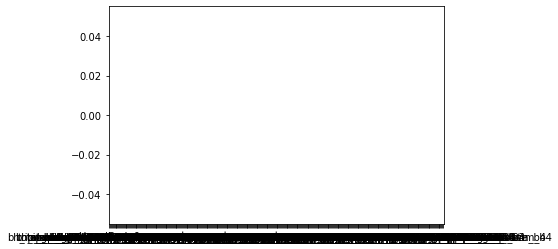

In [ ]:
plt.xticks()
#plt.figure(figsize=(20, 10))
sns.barplot(x=df.isnull().sum().index, y=df.isnull().sum()/df.shape[0])

In [ ]:

df_t  = pd.read_csv('/content/drive/MyDrive/DataSet2020/transformed_dataset.csv' ,low_memory=False)
df_t.head()

,covid_vaccination,sex_cd,bh_ip_snf_mbr_resp_pmpm_cost_9to12m_b4,auth_3mth_acute_inf,rx_maint_pmpm_ct_t_6-3-0m_b4,auth_3mth_home,rx_mail_mbr_resp_pmpm_cost_t_9-6-3m_b4,cms_orig_reas_entitle_cd,auth_3mth_post_acute_mus,auth_3mth_acute_dia,src_div_id,atlas_type_2015_recreation_no,auth_3mth_acute_inj,auth_3mth_dc_ltac,rx_nonbh_pmpm_ct_t_9-6-3m_b4,auth_3mth_acute_bld,total_physician_office_net_paid_pmpm_cost_t_9-6-3m_b4,auth_3mth_acute_ccs_153,atlas_hiamenity,rx_maint_pmpm_cost_t_6-3-0m_b4,atlas_population_loss_2015_update,rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4,rx_overall_mbr_resp_pmpm_cost_t_6-3-0m_b4,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4,auth_3mth_bh_acute,rx_overall_dist_gpi6_pmpm_ct_t_6-3-0m_b4,rev_cms_ansth_pmpm_ct,auth_3mth_post_acute_end,atlas_persistentchildpoverty_1980_2011,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,auth_3mth_post_acute_dig,auth_3mth_post_acute_cir,auth_3mth_bh_acute_mean_los,auth_3mth_dc_home,auth_3mth_post_acute,rx_gpi2_33_pmpm_ct_0to3m_b4,total_med_net_paid_pmpm_cost_t_6-3-0m_b4,total_allowed_pmpm_cost_t_9-6-3m_b4,auth_3mth_post_acute_ckd,auth_3mth_acute_mus,...,atlas_pct_laccess_nhna15,atlas_totalocchu,atlas_pct_laccess_lowi15,atlas_pct_nslp15,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,cms_tot_partd_payment_amt,rx_maint_pmpm_ct_9to12m_b4,rx_nonbh_mbr_resp_pmpm_cost_6to9m_b4,atlas_pct_sfsp15,rwjf_air_pollute_density,atlas_pct_cacfp15,bh_ncdm_pct,atlas_pc_ffrsales12,rx_nonbh_net_paid_pmpm_cost,total_outpatient_allowed_pmpm_cost_6to9m_b4,atlas_pct_fmrkt_wic16,credit_bal_consumerfinance,rx_nonbh_pmpm_ct_0to3m_b4,atlas_berry_acrespth12,rx_overall_mbr_resp_pmpm_cost,rx_branded_mbr_resp_pmpm_cost,rx_tier_2_pmpm_ct_3to6m_b4,credit_bal_autobank,atlas_pct_laccess_child15,atlas_pct_laccess_nhasian15,atlas_dirsales_farms12,rx_hum_16_pmpm_ct,atlas_pct_laccess_hhnv15,rx_days_since_last_script_6to9m_b4,atlas_pct_laccess_snap15,atlas_povertyunder18pct,atlas_medhhinc,auth_3mth_acute_mean_los,atlas_veg_acrespth12,atlas_netmigrationrate1016,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_multir15,rx_nonotc_dist_gpi6_pmpm_ct,atlas_pct_obese_adults13,atlas_orchard_acrespth12
0,0,1,1,0,0,1,4,0,0,0,2,0,0,1,4,1,9,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0,1,1,1,2,9,9,0,0,...,0.036550,16416.0,8.809361,12.218996,0.00,28.89,1.333333,50.546665,0.534684,8.0,1.412746,0.0,479.492780,24.014165,0.00,0.0,832.960852,2.000000,0.000000,14.424166,0.0,1.000000,6434.326769,7.910346,0.071579,17.0,0.833333,1.150322,217,1.458254,18.3,56861.0,0.0,4.181879,9.775188,0.0,1.260405,0.500000,33.2,0.000000
1,0,1,2,0,0,1,8,0,0,0,2,0,0,1,8,1,9,0,0,4,0,2,4,8,1,4,1,0,0,1,0,0,1,1,1,2,9,9,0,0,...,0.028851,99660.0,4.217246,11.180060,0.00,28.81,0.000000,0.000000,0.961838,10.3,1.704639,0.0,521.238200,9.497500,0.00,0.0,814.885956,3.666667,0.043390,27.267500,0.0,1.666667,7183.751526,1.730272,0.280467,116.0,1.250000,2.447362,120,1.063555,12.6,55828.0,0.0,0.646902,9.931234,0.0,0.310503,1.250000,32.9,0.156425
2,0,1,1,0,10,1,10,1,0,0,2,0,0,1,8,1,1,0,0,10,0,1,4,0,1,4,11,0,0,1,0,0,1,1,1,1,4,2,0,0,...,0.086740,23811.0,7.809896,9.865436,0.17,151.83,0.333333,0.000000,1.359437,9.0,0.800732,0.0,632.196141,4.733333,4192.19,0.0,1796.896312,1.333333,0.040506,23.571666,0.0,0.000000,4952.314364,5.015501,0.000395,33.0,0.000000,2.212277,231,2.516320,17.3,61903.0,0.0,7.431193,5.555760,0.0,0.773873,0.333333,35.0,1.037510
3,0,1,1,0,0,1,4,0,0,0,2,0,0,1,0,1,9,0,0,1,0,1,1,0,1,10,1,0,0,1,0,0,1,1,1,1,9,11,0,0,...,0.167049,70150.0,10.317817,12.101522,0.00,83.67,1.333333,27.413333,0.991095,10.7,1.387364,0.0,666.146008,1.697500,0.00,0.0,961.138780,1.333333,0.000000,6.016667,0.0,0.000000,3840.454257,4.049586,0.849008,3.0,0.416667,1.527418,199,5.050701,33.7,41694.0,0.0,0.027000,2.118735,0.0,1.950803,0.416667,37.1,9.094149
4,0,1,1,0,1,1,9,0,0,0,2,0,0,1,4,1,9,0,1,1,0,1,9,4,1,10,1,0,0,1,0,0,1,1,1,4,9,9,0,0,...,0.035950,106124.0,3.923556,8.358339,0.00,76.15,1.333333,0.000000,0.327121,8.7,1.438477,0.0,642.487457,48.255000,0.00,30.0,540.459213,1.666667,0.322768,0.000000,0.0,0.333333,6185.369020,0.618606,0.885394

In [ ]:
len(df_t.columns)

331

Checking for Null values

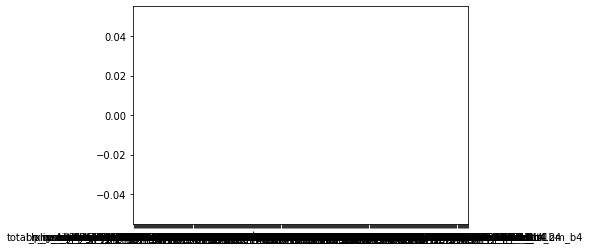

In [ ]:
plt.xticks()
#plt.figure(figsize=(20, 10))
sns.barplot(x=df_t.isnull().sum().index, y=df_t.isnull().sum()/df_t.shape[0])